In [1]:
import pandas as pd
import numpy as np
import os
import collections
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams.update({"font.size":20})
pd.set_option('display.max_columns', 500)

In [3]:
import seaborn as sns

In [4]:
os.listdir("../data/")

['test_transaction.csv',
 '.DS_Store',
 'train_identity.csv',
 'test_identity.csv',
 'sample_submission.csv',
 'train_transaction.csv']

# Read Data

In [5]:
past = time.time()
features_train = pd.read_csv("../data/train_transaction.csv")
features_test = pd.read_csv("../data/test_transaction.csv")
print(time.time() - past)

50.18263006210327


## Seperate Y from the data

In [6]:
Y = features_train[["TransactionID", "isFraud"]]
features_train.drop("isFraud", axis="columns", inplace=True)

## combine training data and testing data, do the feature engineer together

In [7]:
df_trans = pd.concat([features_train, features_test])

## use information of id

In [8]:
past = time.time()
id_train = pd.read_csv("../data/train_identity.csv")
id_test = pd.read_csv("../data/test_identity.csv")
print(time.time() - past)

1.2399492263793945


In [9]:
df_id = pd.concat([id_train, id_test])

In [10]:
df_train = df_trans.merge(df_id, on="TransactionID", how="left")

### 1. do the time stuff

In [11]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_train["Date"] = df_train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_train['Weekdays'] = df_train['Date'].dt.dayofweek
df_train['Hours'] = df_train['Date'].dt.hour
df_train['Days'] = df_train['Date'].dt.day

### 2. drop columns contains larger than 95% of missing values

In [12]:
NA_sum = df_train.isna().sum()

In [13]:
threshold = 0.95
drop_cols = NA_sum[NA_sum > df_train.shape[0] * threshold].index
print(drop_cols)

Index(['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26',
       'id_27'],
      dtype='object')


In [14]:
df_train.drop(drop_cols, axis="columns", inplace=True)

### 3. categorical, i want to try something different: columns with number of unique values less than 10 will be treated as categorical variables

In [15]:
nunique = df_train.nunique()

In [16]:
categorical_col = nunique[(nunique<10) | (df_train.dtypes == 'object')].index
print(categorical_col)

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V21', 'V22', 'V27', 'V28', 'V29', 'V30', 'V35',
       'V36', 'V41', 'V42', 'V46', 'V48', 'V49', 'V50', 'V51', 'V53', 'V54',
       'V57', 'V61', 'V63', 'V65', 'V66', 'V68', 'V69', 'V70', 'V71', 'V73',
       'V75', 'V76', 'V79', 'V82', 'V83', 'V88', 'V89', 'V90', 'V91', 'V92',
       'V93', 'V94', 'V107', 'V108', 'V109', 'V110', 'V117', 'V118', 'V119',
       'V120', 'V121', 'V122', 'V141', 'V174', 'V194', 'V240', 'V241', 'V286',
       'V305', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31',
       'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'Weekdays'],
      dtype='object')


** if the number of unique value is larger than 20, sort the value_counts, keep the top20, re-name the rest "Other" **

In [17]:
def reduce_category(df, col):
    keep = df[col].value_counts().head(20).index
    df.loc[(~df[col].isna()) & (~df[col].isin(keep)), col] = "Other"

In [18]:
for col in categorical_col:
    if nunique[col] > 20:
        reduce_category(df_train, col)

In [19]:
one_hot_features = pd.get_dummies(df_train[categorical_col].astype("object"), dummy_na=True)
one_hot_features.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,card4_american express,card4_discover,card4_mastercard,card4_visa,card4_nan,card6_charge card,card6_credit,card6_debit,card6_debit or credit,card6_nan,P_emaildomain_Other,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_gmail.com,P_emaildomain_hotmail.com,P_emaildomain_icloud.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_sbcglobal.net,P_emaildomain_verizon.net,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_ymail.com,P_emaildomain_nan,R_emaildomain_Other,R_emaildomain_anonymous.com,R_emaildomain_aol.com,R_emaildomain_att.net,R_emaildomain_bellsouth.net,R_emaildomain_comcast.net,R_emaildomain_cox.net,R_emaildomain_gmail.com,R_emaildomain_hotmail.com,R_emaildomain_hotmail.fr,R_emaildomain_icloud.com,R_emaildomain_live.com,R_emaildomain_live.com.mx,R_emaildomain_me.com,R_emaildomain_msn.com,R_emaildomain_outlook.com,R_emaildomain_outlook.es,R_emaildomain_sbcglobal.net,R_emaildomain_verizon.net,R_emaildomain_yahoo.com,R_emaildomain_yahoo.com.mx,R_emaildomain_nan,M1_F,M1_T,M1_nan,M2_F,M2_T,M2_nan,M3_F,M3_T,M3_nan,M4_M0,M4_M1,M4_M2,M4_nan,M5_F,M5_T,M5_nan,M6_F,M6_T,M6_nan,M7_F,M7_T,M7_nan,M8_F,M8_T,M8_nan,M9_F,M9_T,M9_nan,V1_0.0,V1_1.0,V1_nan,V10_0.0,V10_1.0,V10_2.0,V10_3.0,V10_4.0,V10_5.0,V10_nan,V11_0.0,V11_1.0,V11_2.0,V11_3.0,V11_4.0,V11_5.0,V11_6.0,V11_7.0,V11_nan,V12_0.0,V12_1.0,V12_2.0,V12_3.0,V12_4.0,V12_nan,V13_0.0,V13_1.0,V13_2.0,V13_3.0,V13_4.0,V13_5.0,V13_6.0,V13_nan,V14_0.0,V14_1.0,V14_nan,V21_0.0,V21_1.0,V21_2.0,V21_3.0,V21_4.0,V21_5.0,V21_nan,V22_0.0,V22_1.0,V22_2.0,V22_3.0,V22_4.0,V22_5.0,V22_6.0,V22_7.0,V22_8.0,V22_nan,V27_0.0,V27_1.0,V27_2.0,V27_3.0,V27_4.0,V27_5.0,V27_6.0,V27_7.0,V27_nan,V28_0.0,V28_1.0,V28_2.0,V28_3.0,V28_4.0,V28_5.0,V28_6.0,V28_7.0,V28_nan,V29_0.0,V29_1.0,V29_2.0,V29_3.0,V29_4.0,V29_5.0,V29_nan,V30_0.0,V30_1.0,V30_2.0,V30_3.0,V30_4.0,V30_5.0,V30_6.0,V30_7.0,V30_9.0,V30_nan,V35_0.0,V35_1.0,V35_2.0,V35_3.0,V35_4.0,V35_nan,V36_0.0,V36_1.0,V36_2.0,V36_3.0,V36_4.0,V36_5.0,V36_6.0,V36_nan,V41_0.0,V41_1.0,V41_nan,V42_0.0,V42_1.0,V42_2.0,V42_3.0,V42_4.0,V42_5.0,V42_6.0,V42_7.0,V42_8.0,V42_nan,V46_0.0,V46_1.0,V46_2.0,V46_3.0,V46_4.0,V46_5.0,V46_6.0,V46_7.0,V46_8.0,V46_nan,V48_0.0,V48_1.0,V48_2.0,V48_3.0,V48_4.0,V48_5.0,V48_nan,V49_0.0,V49_1.0,V49_2.0,V49_3.0,V49_4.0,V49_5.0,V49_6.0,V49_7.0,V49_nan,V50_0.0,V50_1.0,V50_2.0,V50_3.0,V50_4.0,V50_5.0,V50_6.0,V50_7.0,V50_nan,V51_0.0,V51_1.0,V51_2.0,V51_3.0,V51_4.0,V51_5.0,V51_6.0,V51_7.0,V51_8.0,V51_nan,V53_0.0,V53_1.0,...,V108_7.0,V108_8.0,V108_nan,V109_0.0,V109_1.0,V109_2.0,V109_3.0,V109_4.0,V109_5.0,V109_6.0,V109_7.0,V109_8.0,V109_nan,V110_0.0,V110_1.0,V110_2.0,V110_3.0,V110_4.0,V110_5.0,V110_6.0,V110_7.0,V110_8.0,V110_nan,V117_0.0,V117_1.0,V117_2.0,V117_3.0,V117_nan,V118_0.0,V118_1.0,V118_2.0,V118_3.0,V118_nan,V119_0.0,V119_1.0,V119_2.0,V119_3.0,V119_nan,V120_0.0,V120_1.0,V120_2.0,V120_3.0,V120_4.0,V120_nan,V121_0.0,V121_1.0,V121_2.0,V121_3.0,V121_4.0,V121_nan,V122_0.0,V122_1.0,V122_2.0,V122_3.0,V122_4.0,V122_nan,V141_0.0,V141_1.0,V141_2.0,V141_3.0,V141_4.0,V141_5.0,V141_6.0,V141_nan,V174_0.0,V174_1.0,V174_2.0,V174_3.0,V174_4.0,V174_5.0,V174_6.0,V174_7.0,V174_8.0,V174_nan,V194_0.0,V194_1.0,V194_2.0,V194_3.0,V194_4.0,V194_5.0,V194_6.0,V194_7.0,V194_nan,V240_0.0,V240_1.0,V240_2.0,V240_3.0,V240_5.0,V240_6.0,V240_7.0,V240_nan,V241_0.0,V241_1.0,V241_2.0,V241_3.0,V241_4.0,V241_5.0,V241_nan,V286_0.0,V286_1.0,V286_2.0,V286_3.0,V286_4.0,V286_5.0,V286_6.0,V286_7.0,V286_8.0,V286_nan,V305_1.0,V305_2.0,V305_nan,id_12_Found,id_12_NotFound,id_12_nan,id_15_Found,id_15_New,id_15_Unknown,id_15_nan,id_16_Found,id_16_NotFound,id_16_nan,id_28_Found,id_28_New,id_28_nan,id_29_Found,id_29_NotFound,id_29_nan,id_30_Android,id_30_Android 7.0,id_30_Android 8.0.0,id_30_

### 4. numerical features

In [20]:
numerical_col = [col for col in df_train.columns if col not in categorical_col]
numerical_col.remove("Date")

#### 4.1 fill with mean

In [21]:
numerical_features = df_train.loc[:, numerical_col].apply(lambda x: x.fillna(x.mean()), axis=0)

In [22]:
numerical_features.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V2,V3,V4,V5,V6,V7,V8,V9,V15,V16,V17,V18,V19,V20,V23,V24,V25,V26,V31,V32,V33,V34,V37,V38,V39,V40,V43,V44,V45,V47,V52,V55,V56,V58,V59,V60,V62,V64,V67,V72,V74,V77,V78,V80,V81,V84,V85,V86,V87,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V111,V112,V113,V114,V115,V116,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,Hours,Days
0,2987000,86400,68.5,13926,363.099769,150.0,142.0,315.0,87.0,19.000000,234.472463,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,178.493856,13.000000,157.700888,46.669268,77.771248,53.888168,153.417191,0.557533,13.000000,13.000000,66.116518,18.117435,58.00937,0.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.123164,1.186014,0.230119,0.244885,0.234133,1.093726,1.13378,1.038193,0.194191,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.037323,1.059183,1.125766,0.055443,5.21177,3.2758,19.70029,0.14923,0.165904,0.759874,0.7683,208.998804,5.970286,8.903478,0.751056,0.755367,0.762049,0.770532,0.809725,0.824358,4399.099312,71815.294472,4.915957,7.396177,5.813694,954.905587,3782.617667,854.375389,2.465157,3.664082,0.185152,1.461817,1.712687,0.130487,0.057764,0.205848,1.505509,2.101015,3.895808,2.867205,0.697763,0.21862,0.634306,0.376151,0.132968,0.164685,1.142779,1.649724,1.004913,1.053328,1.311563,1.051939,1.185841,1.121687,0.961857,1.073674,0.941802,0.975293,1.367738,1.11022,1.183867,337.054202,770.745066,503.088124,19.768791,7.685585,59.743272,8.958781,31.545588,14.638529,263.009527,504.517602,352.655575,51.0152,135.414109,84.525282,1.021403,1.68001,1.338391,0.186344,1.280416,1.556054,0.094518,0.351539,0.178384,0.257192,0.145645,1.498705,1.847067,1.669009,0.742746,1.042721,0.92596,2.595396,0.170693,0.267594,0.219068,0.127642,0.137117,1.114245,1.179812,1.118818,0.853777,1.297393,1.021617,1.063941,1.039894,0.773887,0.784478,1.026843,1.140147,1.064097,0.787663,0.803191,1.366242,1.503333,0.94969,0.965025,1.111363,1.017032,189.182842,294.838738,239.440827,13.767583,37.124287,22.119071,10.337375,7.464514,11.035032,8.265659,121.161362,168.460909,142.412964,50.48023,83.285972,70.512257,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,3.436303,7.381586,5.097354,0.053407,0.673716,0.232438,0.280806,0.902596,0.551574,526.015297,925.560

#### 4.2 fill with random sample

In [23]:
numerical_features_2 = df_train[numerical_col].copy()

In [24]:
for col in numerical_col:
    n = numerical_features_2[col].isna().sum()
    if n > 0:
        fill = np.random.choice(numerical_features_2.loc[~numerical_features_2[col].isna(), col], n)
        numerical_features_2.loc[numerical_features_2[col].isna(), col] = fill

### 5. combine

In [23]:
train = numerical_features.join(one_hot_features)

In [24]:
train.isna().sum().sum()

0

In [25]:
random_index = np.random.choice(np.arange(train.shape[0]), 10000)

In [26]:
corr = train.iloc[random_index].corr()

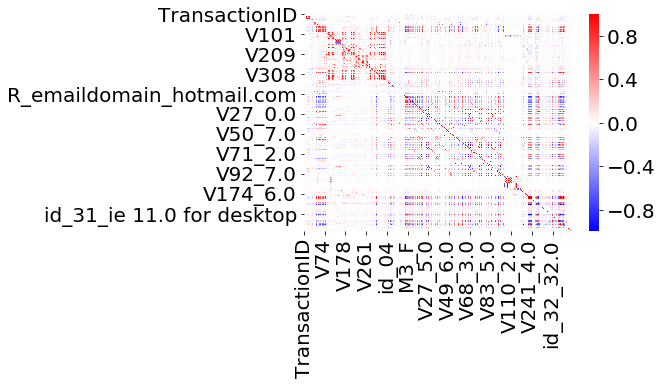

In [28]:
sns.heatmap(corr, cmap="bwr", vmax=1, vmin=-1)

In [31]:
train.drop("TransactionDT", axis="columns", inplace=True)

In [32]:
train.head()

,TransactionID,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V2,V3,V4,V5,V6,V7,V8,V9,V15,V16,V17,V18,V19,V20,V23,V24,V25,V26,V31,V32,V33,V34,V37,V38,V39,V40,V43,V44,V45,V47,V52,V55,V56,V58,V59,V60,V62,V64,V67,V72,V74,V77,V78,V80,V81,V84,V85,V86,V87,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V111,V112,V113,V114,V115,V116,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,...,V108_7.0,V108_8.0,V108_nan,V109_0.0,V109_1.0,V109_2.0,V109_3.0,V109_4.0,V109_5.0,V109_6.0,V109_7.0,V109_8.0,V109_nan,V110_0.0,V110_1.0,V110_2.0,V110_3.0,V110_4.0,V110_5.0,V110_6.0,V110_7.0,V110_8.0,V110_nan,V117_0.0,V117_1.0,V117_2.0,V117_3.0,V117_nan,V118_0.0,V118_1.0,V118_2.0,V118_3.0,V118_nan,V119_0.0,V119_1.0,V119_2.0,V119_3.0,V119_nan,V120_0.0,V120_1.0,V120_2.0,V120_3.0,V120_4.0,V120_nan,V121_0.0,V121_1.0,V121_2.0,V121_3.0,V121_4.0,V121_nan,V122_0.0,V122_1.0,V122_2.0,V122_3.0,V122_4.0,V122_nan,V141_0.0,V141_1.0,V141_2.0,V141_3.0,V141_4.0,V141_5.0,V141_6.0,V141_nan,V174_0.0,V174_1.0,V174_2.0,V174_3.0,V174_4.0,V174_5.0,V174_6.0,V174_7.0,V174_8.0,V174_nan,V194_0.0,V194_1.0,V194_2.0,V194_3.0,V194_4.0,V194_5.0,V194_6.0,V194_7.0,V194_nan,V240_0.0,V240_1.0,V240_2.0,V240_3.0,V240_5.0,V240_6.0,V240_7.0,V240_nan,V241_0.0,V241_1.0,V241_2.0,V241_3.0,V241_4.0,V241_5.0,V241_nan,V286_0.0,V286_1.0,V286_2.0,V286_3.0,V286_4.0,V286_5.0,V286_6.0,V286_7.0,V286_8.0,V286_nan,V305_1.0,V305_2.0,V305_nan,id_12_Found,id_12_NotFound,id_12_nan,id_15_Found,id_15_New,id_15_Unknown,id_15_nan,id_16_Found,id_16_NotFound,id_16_nan,id_28_Found,id_28_New,id_28_nan,id_29_Found,id_29_NotFound,id_29_nan,id_30_Android,id_30_Android 7.0,id_30_Android 8.0.0,id_30_Linux,id_30_Mac OS X 10_10_5,id_30_Mac OS X 10_11_6,id_30_Mac OS X 10_12_6,id_30_Mac OS X 10_13_6,id_30_Other,id_30_Windows 10,id_30_Windows 7,id_30_Windows 8.1,id_30_iOS 10.3.3,id_30_iOS 11.1.2,id_30_iOS 11.2.1,id_30_iOS 11.2.6,id_30_iOS 11.3.0,id_30_iOS 11.4.0,id_30_iOS 11.4.1,id_30_iOS 12.0.1,id_30_iOS 12.1.0,id_30_nan,id_31_Other,id_31_chrome 62.0,id_31_chrome 63.0,id_31_chrome 63.0 for android,id_31_chrome 64.0,id_31_chrome 65.0,id_31_chrome 67.0,id_31_chrome 68.0,id_31_chrome 69.0,id_31_chrome 69.0 for android,id_31_chrome 70.0,id_31_chrome 70.0 for android,id_31_chrome 71.0,id_31_chrome 71.0 for android,id_31_chrome generic,id_31_edge 17.0,id_31_ie 11.0 for desktop,id_31_mobile safari 11.0,id_31_mobile safari 12.0,id_31_mobile safari generic,id_31_safari generic,id_31_nan,id_32_0.0,id_32_8.0,id_32_16.0,id_32_24.0,id_32_32.0,id_32_48.0,id_32_nan,id_33_1024x768,id_33_1136x640,id_33_1280x1024,id_33_1280x720,id_33_1280x800,id_33_1334x750,id_33_1366x768,id_33_1440x900,id_33_1600x900,id_33_1680x1050,id_33_1920x1080,id_33_1920x1200,id_33_2001x1125,id_33_2048x1536,id_33_2208x1242,id_33_2220x1080,id_33_2436x1125,id_33_2560x1440,id_33_2560x1600,id_33_2880x1800,id_33_Other,id_33_nan,id_34_match_status:-1,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,id_35_F,id_35_T,id_35_nan,id_36_F,id_36_T,id_36_nan,id_37_F,id_37_T,id_37_nan,id_38_F,id_38_T,id_38_nan,DeviceType_desktop,DeviceType_mobile,DeviceType_nan,DeviceInfo_ALE-L23 Build/HuaweiALE-L23,DeviceInfo_MacOS,DeviceInfo_Moto G (4) Build/NPJ25.93-14.7,DeviceInfo_Other,DeviceInfo_SAMSUN

In [33]:
result = train.merge(Y, on="TransactionID", how="left")

In [37]:
result.to_csv("../processed_data/fillna_with_mean.csv", index=False)

In [25]:
train2 = numerical_features_2.join(one_hot_features)

In [26]:
result2 = train2.merge(Y, on="TransactionID", how="left")

# Model

In [38]:
X = result[~result.isFraud.isna()].drop(["TransactionID", "isFraud"], axis="columns")
Y = result.loc[~result.isFraud.isna(), "isFraud"]
X_finaltest = result[result.isFraud.isna()].drop(["TransactionID", "isFraud"], axis="columns")
Y_finaltest = result.loc[result.isFraud.isna(), "TransactionID"]

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [28]:
def confusion_matrix(y_true, y_pred):
    TP = sum((y_pred == 1) & (y_true == 1))
    TN = sum((y_pred == 0) & (y_true == 0))
    FP = sum((y_pred == 1) & (y_true == 0))
    FN = sum((y_pred == 0) & (y_true == 1))
    print("{}TP | {}FP\n-----------------\n{}FN | {}TN".format(TP, FP, FN, TN))
    
    recall = 1.0*TP/(TP+FN)
    precision = 1.0*TP/(TP+FP)
    accuracy = 1.0*(TP+TN)/(TP+FP+TN+FN)
    
    f1 = 2.0/ (1/recall + 1/precision)
    print("\naccuracy: {:.4}, recall: {:.4}, precision: {:.4}, F-1 score: {:.4}".format(accuracy, recall, precision, f1))
    return TP, TN, FP, FN, recall, precision, f1

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

In [42]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(472432, 1033) (118108, 1033) (472432,) (118108,)


In [29]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
%%time
RF = RandomForestClassifier(n_estimators=100, max_depth=100, class_weight='balanced')
RF.fit(X_train, y_train)

CPU times: user 5min 42s, sys: 10.5 s, total: 5min 53s
Wall time: 5min 56s


In [45]:
TP, TN, FP, FN, recall, precision, f1 = confusion_matrix(y_test, RF.predict(X_test))

1673TP | 93FP
-----------------
2384FN | 113958TN

accuracy: 0.979, recall: 0.4124, precision: 0.9473, F-1 score: 0.5746


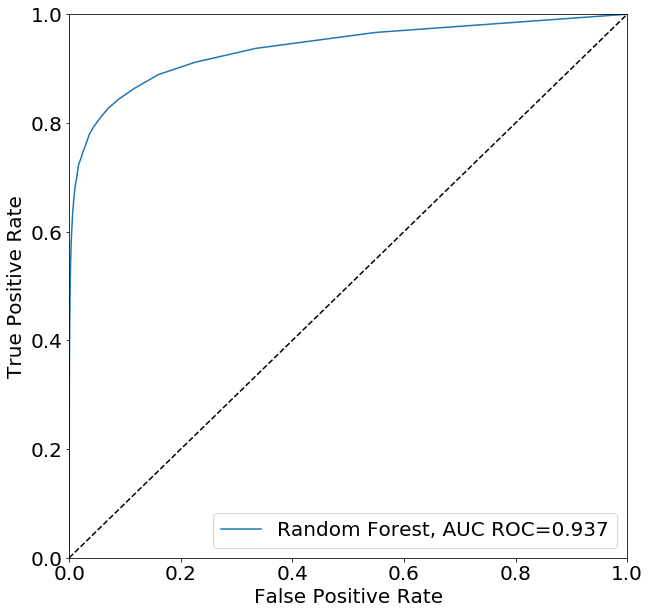

In [46]:
plt.figure(figsize=(10,10))
prob = RF.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, prob[:,1])
plt.plot(fpr, tpr, label="Random Forest, AUC ROC={:.3}".format(roc_auc_score(y_test, prob[:,1])))
plt.axis([0,1,0,1])
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [48]:
prob = RF.predict_proba(X_finaltest)

In [49]:
pd.DataFrame({"TransactionID": Y_finaltest, "isFraud": prob[:,1]}).to_csv("../submissions/RF.csv", index=False)

## using another feature

In [30]:
X = result2[~result2.isFraud.isna()].drop(["TransactionID", "isFraud"], axis="columns")
Y = result2.loc[~result2.isFraud.isna(), "isFraud"]
X_finaltest = result2[result2.isFraud.isna()].drop(["TransactionID", "isFraud"], axis="columns")
Y_finaltest = result2.loc[result2.isFraud.isna(), "TransactionID"]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

In [32]:
%%time
RF = RandomForestClassifier(n_estimators=100, max_depth=100, class_weight='balanced')
RF.fit(X_train, y_train)

CPU times: user 6min 32s, sys: 8.2 s, total: 6min 40s
Wall time: 6min 43s


In [33]:
TP, TN, FP, FN, recall, precision, f1 = confusion_matrix(y_test, RF.predict(X_test))

1411TP | 86FP
-----------------
2646FN | 113965TN

accuracy: 0.9769, recall: 0.3478, precision: 0.9426, F-1 score: 0.5081


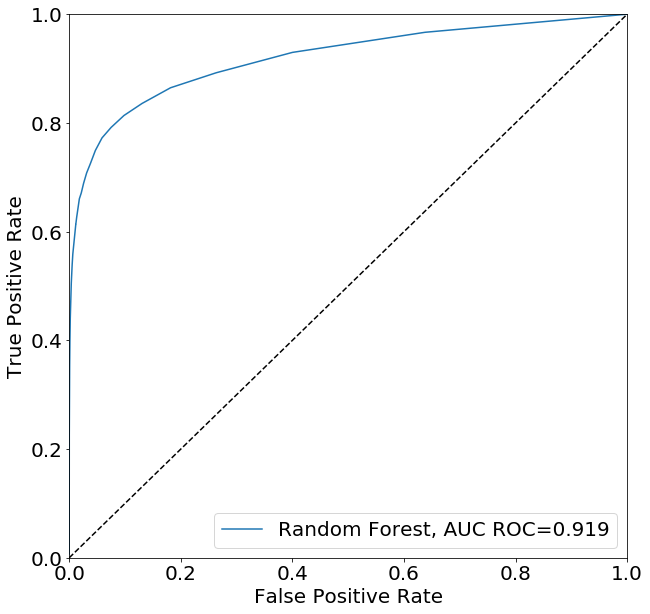

In [34]:
plt.figure(figsize=(10,10))
prob = RF.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, prob[:,1])
plt.plot(fpr, tpr, label="Random Forest, AUC ROC={:.3}".format(roc_auc_score(y_test, prob[:,1])))
plt.axis([0,1,0,1])
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [35]:
prob = RF.predict_proba(X_finaltest)

In [37]:
pd.DataFrame({"TransactionID": Y_finaltest, "isFraud": prob[:,1]}).to_csv("../submissions/fill_with_random_RF.csv", index=False)